# Ensemble Analysis

This example compares experimental structural data analyzed using Principal Component Analysis (PCA) with the theoretical data predicted by Anisotropic Network Model (ANM):

First make the necessary imports:

In [3]:
from prody import *
from numpy import *
from matplotlib.pyplot import *

## Retrieve dataset

One way to retrieve data is to run an NCBI BLAST search against the PDB with the function blastPDB.

To do this, we first need to obtain a sequence and one way to do that is from the PDB:

In [4]:
p38 = parsePDB('1p38', compressed=False) # MAP KINASE

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> pdb1p38.ent.gz download failed. 1p38 does not exist on ftp.wwpdb.org.
@> PDB download via FTP completed (0 downloaded, 1 failed).
@> Downloading PDB files via FTP failed, trying HTTP.
@> 1p38 downloaded (1p38.pdb)
@> PDB download via HTTP completed (1 downloaded, 0 failed).
@> 2962 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> Secondary structures were assigned to 188 residues.


We just want one sequence, so we get the sequence of chain A from the pdb file

In [5]:
p38_sequence = p38['A'].getSequence()
p38_sequence

'ERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGHRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSLEEFNDVYLVTHLMGADLNNIVKCQKLTDDHVQFLIYQILRGLKYIHSADIIHRDLKPSNLAVNEDCELKILDFGLARHTDDEMTGYVATRWYRAPEIMLNWMHYNQTVDIWSVGCIMAELLTGRTLFPGTDHIDQLKLILRLVGTPGAELLKKISSESARNYIQSLAQMPKMNFANVFIGANPLAVDLLEKMLVLDSDKRITAAQALAHAYFAQYHDPDDEPVADPYDQSFESRDLLIDEWKSLTYDEVISFVPPPLD'

Once we have this sequence, we can use it in the function [`blastPDB`](http://prody.csb.pitt.edu/manual/reference/proteins/blastpdb.html?highlight=blastpdb#prody.proteins.blastpdb.blastPDB). We also provide a filename to save the output so we don't need to run it again. To reduce demand on the NCBI webserver, we have provided you this file so please do not run this command.

Instead, please load the data from the pickle file provided:

In [6]:
import pickle

blast_record = pickle.load(open('blast_record3.pkl', 'rb'))

In [7]:
blast_record

We can get hits from this record using certain parameters to filter them and extract a list of PDB IDs from them.

In [8]:
hits = blast_record.getHits(percent_identity=90, percent_overlap=70)

In [9]:
pdbids = list(hits.keys())
len(pdbids)

253

In [10]:
pdbids[:10]

['1lew',
 '1lez',
 '4ka3',
 '4loo',
 '4lop',
 '4loq',
 '5lar',
 '3tg1',
 '1bmk',
 '5uoj']

Next, we will use the [`parsePDB`](http://prody.csb.pitt.edu/manual/reference/proteins/pdbfile.html?highlight=parsepdb#prody.proteins.pdbfile.parsePDB) function to import each one of the structures corresponding to these IDs. 

Before doing that, we will make a folder to put them in (if it doesn't already exist) and configure *ProDy* to use that folder with the function [`pathPDBFolder`](http://prody.csb.pitt.edu/manual/reference/proteins/localpdb.html?highlight=pathpdbfolder#prody.proteins.localpdb.pathPDBFolder). 

In [11]:
from os import mkdir
from os.path import isdir

if not isdir('pdbs'):
    mkdir('pdbs')

In [12]:
pathPDBFolder('pdbs')

@> Local PDB folder is set: '/Users/bentley/Dropbox/Pitt/Bahar/MMBioS/2021/notebooks/pdbs'
@> A plain folder structure will be assumed.


In [13]:
pdbs = parsePDB(pdbids)

@> Retrieving 1ian... [ 48%] 61s @> WARNING header does not contain secondary structure data
@> 253 PDBs were parsed in 104.41s.


After parsing the structures from the PDB, we can use this function again to reset the default download folder back to our current directory:

In [14]:
pathPDBFolder('')

@> PDB folder '/Users/bentley/Dropbox/Pitt/Bahar/MMBioS/2021/notebooks/pdbs' is released.


## Set reference chain

Next, we make a selection to use as the reference for ensemble building:

In [15]:
ref_structure = p38
ref_selection = ref_structure.select('resnum 5 to 31 36 to 114 122 to '
                                     '169 185 to 351 and calpha')

We extract chain A by indexing to get a [`Chain`](http://prody.csb.pitt.edu/manual/reference/atomic/chain.html?highlight=chain#prody.atomic.chain.Chain) object to make things easier.

In [16]:
ref_chain = ref_selection['A']
repr(ref_chain)

'<Chain: A from 1p38 (321 residues, 321 atoms)>'

## Ensemble Preparation

We will prepare a [`PDBEnsemble`](http://prody.csb.pitt.edu/manual/reference/ensemble/pdbensemble.html?highlight=pdbensemble#module-prody.ensemble.pdbensemble) by mapping each structure against the reference chain and adding a coordinates set corresponding to the mapped atoms. We first make sure that our list of PDB structures (**pdbs**) includes the **ref_chain**.

In [17]:
pdbs.insert(0, ref_chain)

In [18]:
ensemble = buildPDBEnsemble(pdbs, ref=ref_chain, title='p38')

@> Starting iterative superposition:          
@> Step #1: RMSD difference = 8.4106e-01
@> Step #2: RMSD difference = 2.7449e-04
@> Step #3: RMSD difference = 2.3113e-07
@> Iterative superposition completed in 0.29s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.20 seconds.
@> Ensemble (254 conformations) were built in 43.42s.


In [19]:
ensemble

<PDBEnsemble: p38 (254 conformations; 321 atoms)>

## Ensemble Dynamics

Now we will examine the structural dynamics of this ensemble using two different methods

### 1. Principal Component Analysis (PCA)

PCA is a method that identifies the components which account for the greatest amount of variability in your dataset, i.e. ensemble. 

In [20]:
pca = PCA('p38 xray')           # Instantiate a PCA instance
pca.buildCovariance(ensemble)   # Build covariance for the ensemble
pca.calcModes()                 # Calculate modes (20 of the by default)

@> Covariance is calculated using 254 coordinate sets.
@> Covariance matrix calculated in 0.099029s.
@> 20 modes were calculated in 0.29s.


The components/modes of variation are sorted such that the first modes contribute the greatest fractional variance, which we can show as follows:

In [21]:
for mode in pca[:5]:    # Print % variance explained by top PCs
    var = calcFractVariance(mode)*100
    print('{0:s}  % variance = {1:.2f}'.format(repr(mode), var))

<Mode: 1 from PCA p38 xray>  % variance = 23.91
<Mode: 2 from PCA p38 xray>  % variance = 17.54
<Mode: 3 from PCA p38 xray>  % variance = 14.22
<Mode: 4 from PCA p38 xray>  % variance = 7.43
<Mode: 5 from PCA p38 xray>  % variance = 5.67


The first modes with the highest fractional variance are called the principal components (PCs).

### 2. Anisotropic Network Model (ANM) Normal Mode Analysis (NMA)

The ANM allows for the identification of the most impactful (slowest) modes in dynamics of a single protein, which we can compare to the principal components from PCA.

In [22]:
anm = ANM('1p38')             # Instantiate a ANM instance
anm.buildHessian(ref_chain)   # Build Hessian for the reference chain
anm.calcModes()               # Calculate slowest non-trivial 20 modes

@> Hessian was built in 0.28s.
@> 20 modes were calculated in 0.21s.


## Analysis of PCA and ANM modes

### Collectivity of modes

One property that we can calculate and compare is the collectivity, which describes the extent to which a mode collectively recruits large portions of the structure. We see that most of the first modes from both calculations are highly collective.

In [23]:
for mode in pca[:3]:    # Print PCA mode collectivity
    coll = calcCollectivity(mode)
    print('{0:s}  collectivity = {1:.2f}'.format(repr(mode), coll))

<Mode: 1 from PCA p38 xray>  collectivity = 0.52
<Mode: 2 from PCA p38 xray>  collectivity = 0.19
<Mode: 3 from PCA p38 xray>  collectivity = 0.61


In [24]:
for mode in anm[:3]:    # Print ANM mode collectivity
    coll = calcCollectivity(mode)
    print('{0:s}  collectivity = {1:.2f}'.format(repr(mode), coll))

<Mode: 1 from ANM 1p38>  collectivity = 0.65
<Mode: 2 from ANM 1p38>  collectivity = 0.55
<Mode: 3 from ANM 1p38>  collectivity = 0.68


### PCA - ANM overlap

We can also look at how well the modes produced from each method correlate with each other using the overlap (correlation cosine).

In [25]:
printOverlapTable(pca[:3], anm[:3]) # Top 3 PCs vs slowest 3 ANM modes

Overlap Table
                        ANM 1p38
                    #1     #2     #3
PCA p38 xray #1   -0.78  -0.02  -0.47
PCA p38 xray #2   -0.33  +0.05  +0.47
PCA p38 xray #3   -0.27  -0.72  +0.31



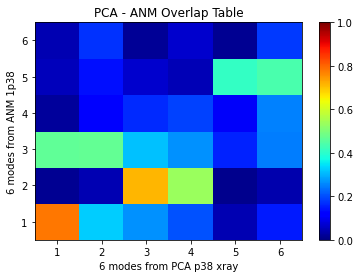

In [26]:
showOverlapTable(pca[:6], anm[:6]);
title('PCA - ANM Overlap Table');

The overlap table shows how each mode from the two methods overlap with each other. Some modes overlap very well with one other mode while others overlap with multiple modes to a lesser extent.

We can also look at the overlap between one mode and all others as follows. The cumulative overlap is the square root of the sum of squared overlaps.

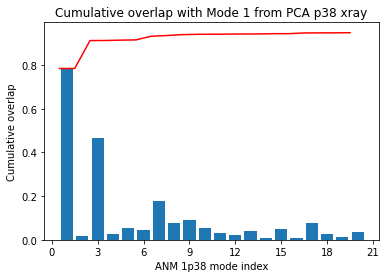

In [27]:
showOverlap(pca[0], anm);
showCumulOverlap(pca[0], anm, color='r');

### Square Fluctuations

In order to see where in the protein these important motions occur, we can visualize the square fluctuations of the principal components and/or slow ANM modes as follows. The function [`showScaledSqFlucts`](http://prody.csb.pitt.edu/manual/reference/dynamics/plotting.html?highlight=showscaledsqflucts#prody.dynamics.plotting.showScaledSqFlucts) allows us to scale the square fluctuations from each set of modes to have the same overall size for easier comparison.

We can apply this to individual modes, such as overlapping mode 1 (index 0) from each method, or multiple modes such as the first 3.

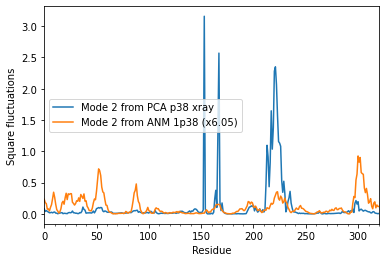

In [28]:
showScaledSqFlucts(pca[1], anm[1]);
legend();

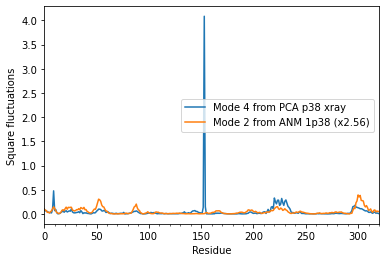

In [29]:
showScaledSqFlucts(pca[3], anm[1]);
legend();

### Cross Correlations

We can also see how correlated the motions for each residue are with each other residue. We see similar patterns for the two methods, especially when using a large number of modes.

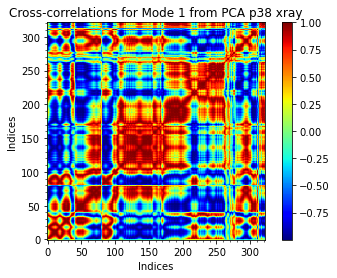

In [30]:
showCrossCorr(pca[0]);

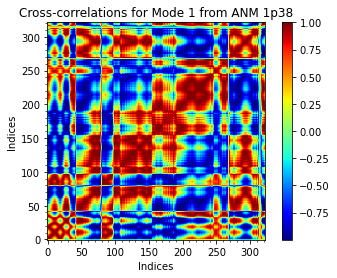

In [31]:
showCrossCorr(anm[0]);

## Saving your work

We can save the outputs from each step for loading back into *ProDy* as follows:

In [32]:
writePDB('p38_ref_chain.pdb', ref_chain)
saveEnsemble(ensemble)
saveModel(pca)
saveModel(anm)

/Users/bentley/opt/anaconda3/envs/workshop/lib/python3.7/site-packages/prody/ensemble/functions.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  attr_dict['_atoms'] = np.array([atoms, None])
/Users/bentley/opt/anaconda3/envs/workshop/lib/python3.7/site-packages/prody/ensemble/functions.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  attr_dict['_msa'] = np.array([msa, None])


'1p38.anm.npz'

We can also prepare outputs in NMD format for visualising in VMD with the normal mode wizard:

In [33]:
writeNMD('p38_pca.nmd',anm,ref_chain)

'p38_pca.nmd'

In [34]:
writeNMD('p38_anm.nmd',pca,ref_chain)

'p38_anm.nmd'